In [1]:
%matplotlib notebook

In [2]:
import os
import sys

In [3]:
import numpy as np

In [4]:
import imageio
from IPython.display import HTML

In [5]:
import matplotlib.pyplot as plt
from matplotlib import ticker
from mpl_toolkits.mplot3d.axes3d import Axes3D
plt.ioff()

In [6]:
import seaborn as sns
sns.set()

In [7]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [8]:
import data.analysis_tools as tools

# Data Preparation

In [9]:
num_runs = 5
max_vis_depth = 4
num_intervals = 10
n = 11

In [10]:
interval_size = 100

## Loading

In [11]:
E = np.zeros((max_vis_depth + 1, num_intervals + 1, n, n))
F = np.zeros((max_vis_depth + 1, num_intervals + 1, n, n))

In [12]:
for run in range(1, num_runs + 1):
    for depth in range(1, max_vis_depth + 1):
        dir_input = "raw/cat_mouse_cheese/depth{}/run{}.txt".format(depth, run)
        with open(os.path.abspath(dir_input)) as f:
            for line in f.readlines():
                line = list(map(int, line.split()))
                a = line[0]
                b = line[1]
                for i in range(2, num_intervals + 2):
                    interval = i - 1
                    eaten = line[i]
                    E[depth][interval][a][b] += eaten / num_runs
                for i in range(num_intervals + 2, 2*num_intervals + 2):
                    interval = i - num_intervals - 1
                    fed = line[i]
                    F[depth][interval][a][b] += fed / num_runs

## Preparation of Improvement Tables

### Calculation

In [13]:
I = np.zeros((max_vis_depth + 1, num_intervals + 1, n, n))

In [14]:
for depth in range(1, max_vis_depth + 1):
    for interval in range(1, num_intervals + 1):
        I[depth][interval] = (F[depth][interval] - F[depth][interval - 1]) / (E[depth][interval] - E[depth][interval - 1])

In [15]:
I_flat = I[1:max_vis_depth + 1, 1:num_intervals + 1].flatten()

In [16]:
i_stats = tools.get_stats(I_flat)
i_stats

ArrayStats(min=0.0, ave=0.082167601195682963, max=0.32258064516129054, range=0.32258064516129054)

### Normalization

In [17]:
I_norm = tools.normalize(I, i_stats)

In [18]:
I_norm_flat = I_norm[1:max_vis_depth + 1, 1:num_intervals + 1].flatten()

In [19]:
i_norm_stats = tools.get_stats(I_norm_flat)
i_norm_stats

ArrayStats(min=0.0, ave=0.25471956370661686, max=1.0, range=1.0)

## Preparation of Mesh Grids

In [20]:
def_depth = 1
def_interval = 10

In [21]:
X_domain = np.linspace(0, 1, n)
X = np.zeros((4, n, n))
X[0] = np.full((n, n), def_depth)
X[1] = np.full((n, n), def_interval * interval_size)
X[2], X[3] = np.meshgrid(X_domain, X_domain)

In [22]:
Y = I_norm[def_depth][def_interval]

In [23]:
y_stats = tools.get_stats(Y)
y_stats

ArrayStats(min=0.0, ave=0.25434879690156259, max=0.79487179487179327, range=0.79487179487179327)

In [25]:
len(X)

4

In [26]:
len(Y)

11

# Data Visualization

## Performance Distribution

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
dist = tools.plot_dist(X=I_norm_flat,
                       ax=ax,
                       file_name='plots/normed_perf_dist_2',
                       yticks=[])
plt.close()

In [25]:
dist

In [26]:
percent_in_lower_half = ((0.0 < I_flat) & (I_flat < 0.5)).sum() / I_flat.size
"{:.2%}".format(percent_in_lower_half)

'96.43%'

## Performance vs. Depth and Time Heatmap

In [27]:
tools.heatmap_preprocess(X=I_norm,
                         num_steps=num_intervals,
                         save_file="plots/depth_heatmap/cmc/frame{:03d}.png",
                         vmin=0.0,
                         vmax=0.5,
                        )

In [28]:
heatmap_vid = tools.animate("plots/depth_heatmap/cmc/frame",
                            "plots/depth_heatmap/cmc/anim")

In [29]:
heatmap_vid

## Regression

In [30]:
model = tools.PolynomialRegression(X, Y)

### Linear model

In [31]:
lin_model = model.process(degree=1)
lin_model.print_func()

0.000000*1 + 0.000000*x0 + 0.000282*x1 + -0.003462*x2 + -0.052490*x3


In [32]:
lin_model.r_squared

0.011280421862783331

### Quadratic model

In [33]:
quad_model = model.process(degree=2)
quad_model.print_func()

0.000000*1 + 0.000000*x0 + 0.000000*x1 + -0.000000*x2 + -0.000000*x3 + 0.000000*x0^2 + 0.000000*x0*x1 + -0.000000*x0*x2 + -0.000000*x0*x3 + 0.000000*x1^2 + -0.000278*x1*x2 + -0.000322*x1*x3 + 0.320577*x2^2 + -0.092674*x2*x3 + 0.315688*x3^2


In [34]:
quad_model.r_squared

0.079148180454456374

### Cubic model

In [35]:
cube_model = model.process(degree=3)
cube_model.print_func()

0.000000*1 + -0.000000*x0 + 0.000001*x1 + -0.000000*x2 + 0.000005*x3 + 0.000000*x0^2 + 0.000000*x0*x1 + -0.000000*x0*x2 + 0.000000*x0*x3 + 0.000000*x1^2 + 0.000000*x1*x2 + 0.000000*x1*x3 + -0.000002*x2^2 + -0.000001*x2*x3 + 0.000002*x3^2 + -0.000000*x0^3 + -0.000000*x0^2*x1 + -0.000000*x0^2*x2 + -0.000000*x0^2*x3 + -0.000000*x0*x1^2 + 0.000000*x0*x1*x2 + 0.000000*x0*x1*x3 + -0.000002*x0*x2^2 + -0.000001*x0*x2*x3 + 0.000002*x0*x3^2 + 0.000000*x1^3 + 0.000001*x1^2*x2 + -0.000001*x1^2*x3 + -0.001720*x1*x2^2 + -0.000948*x1*x2*x3 + 0.001509*x1*x3^2 + 0.917153*x2^3 + 1.329795*x2^2*x3 + -0.474357*x2*x3^2 + -0.637491*x3^3


In [36]:
cube_model.r_squared

0.171093500467945

## 3D Plotting

### Linear Estimate

In [37]:
ax = tools.plot_3d_normed(model, degree=1, offsets=(1.5, 1.5, 1))

<IPython.core.display.Javascript object>


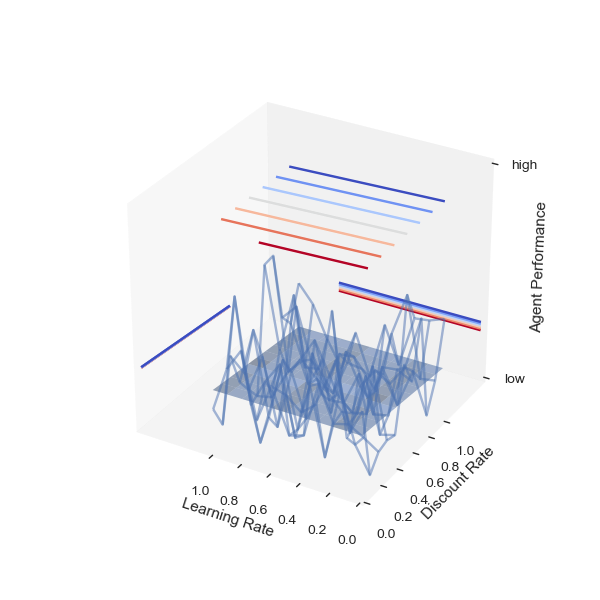

In [38]:
plt.show()

In [39]:
# tools.plot_3d_rotate(ax, save_file="plots/cmc_regression/degree{}/frame{}.jpeg", degree=1)

In [40]:
# for ii in range(0, 360, 1):
#     ax.view_init(elev=30., azim=ii)
#     plt.savefig("plots/cmc_regression/degree{}/frame{}.png".format(1, ii), transparent=True)

In [41]:
plt.close()

### Quadratic Estimate

In [42]:
ax = tools.plot_3d_normed(model, degree=2, offsets=(1.5, 1.5, 1))

<IPython.core.display.Javascript object>


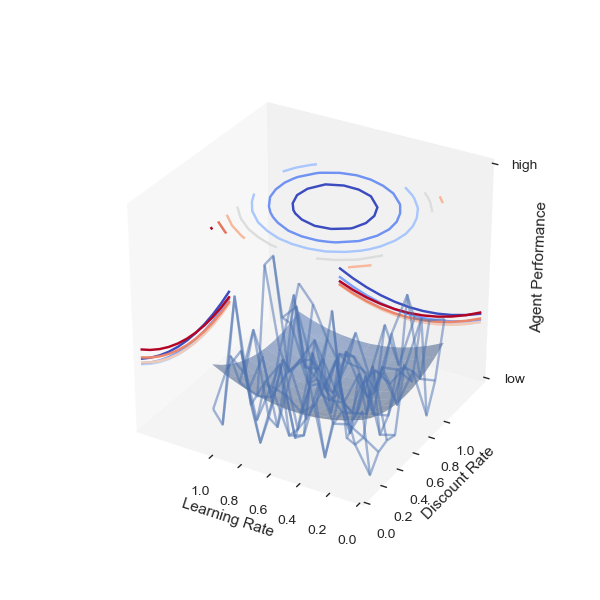

In [43]:
plt.show()

In [44]:
# tools.plot_3d_rotate(ax, save_file="plots/cmc_regression/degree{}/frame{}.jpeg", degree=1)

In [45]:
# for ii in range(0, 360, 1):
#     ax.view_init(elev=30., azim=ii)
#     plt.savefig("plots/cmc_regression/degree{}/frame{}.png".format(1, ii), transparent=True)

In [46]:
plt.close()

### Cubic Estimate

In [47]:
ax = tools.plot_3d_normed(model, degree=3, offsets=(1.5, 1.5, 1))

<IPython.core.display.Javascript object>


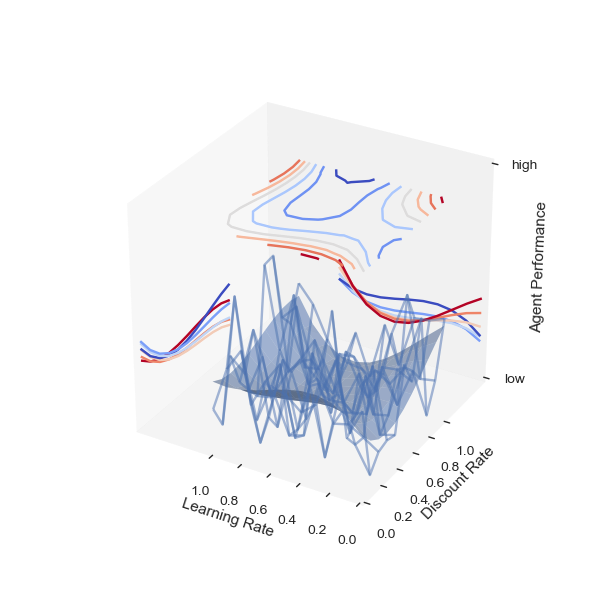

In [48]:
plt.show()

In [44]:
# tools.plot_3d_rotate(ax, save_file="plots/cmc_regression/degree{}/frame{}.jpeg", degree=1)

In [49]:
# for ii in range(0, 360, 1):
#     ax.view_init(elev=30., azim=ii)
#     plt.savefig("plots/cmc_regression/degree{}/frame{}.png".format(1, ii), transparent=True)

In [50]:
plt.close()